# Annotations Demo
Demonstrate how to add annotations to an image in Concentriq LS using a simple tissue detection algorithm as an example.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml

from proscia_ai_tools.concentriqlsclient import ConcentriqLSClient
from proscia_ai_tools.client import ClientWrapper as ConcentriqEmbeddingsClient

In [2]:
with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

ce_api_client = ConcentriqEmbeddingsClient(**creds, device='cpu')
ce_api_client

In [3]:
with open('creds.yml', 'r') as file:
    creds = yaml.safe_load(file)

cls = ConcentriqLSClient(**creds)

In [4]:
image_id = 6538
repo_id = cls.get_image_data(image_id=image_id).get("imageSetId")
repo_id

1987

Fetch a thumbnail for our image

In [5]:
#thumbnail_ticket_id = ce_api_client.thumbnail_images([image_id])
thumbnail_ticket_id = '1f9a0df4-cd1d-424b-a6cb-33326dd39444'
thumbnails = ce_api_client.get_thumbnails(thumbnail_ticket_id)

(-0.5, 1973.5, 2003.5, -0.5)

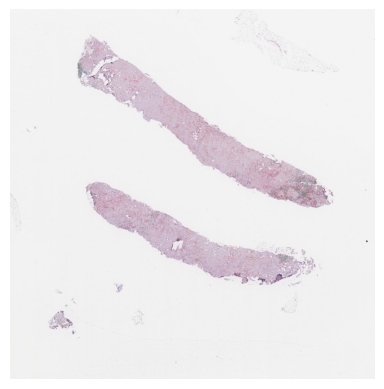

In [6]:
thumbnail = thumbnails['thumbnails'][0]['thumbnail']
plt.imshow(thumbnail)
plt.axis('off')

In [7]:
def simple_tissue_otsu(thumbnail):
    """
    Simple tissue detection using Otsu thresholding
    
    Args:
    thumbnail: np.array
        Thumbnail image
    """
    # convert to gray scale
    img = cv2.cvtColor(thumbnail, cv2.COLOR_BGR2GRAY)
    _, res = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
    )

    # remove noise
    raw_mask = (res==0).astype(np.uint8)
    noise_removal_kernel = np.ones((3, 3), np.uint8)
    noise_mask = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, noise_removal_kernel)

    # fill small gaps
    fill_gaps_kernel = np.ones((20, 20), np.uint8)
    filled_mask = cv2.morphologyEx(noise_mask, cv2.MORPH_CLOSE, fill_gaps_kernel)

    # remove small objects
    remove_small_objects_kernel = np.ones((10, 10), np.uint8)
    mask = cv2.morphologyEx(filled_mask, cv2.MORPH_OPEN, remove_small_objects_kernel)

    # dilate
    dilate_kernel = np.ones((10, 10), np.uint8)
    mask = cv2.dilate(mask, dilate_kernel, iterations=1)

    return mask

Run simple tissue detection

(-0.5, 1973.5, 2003.5, -0.5)

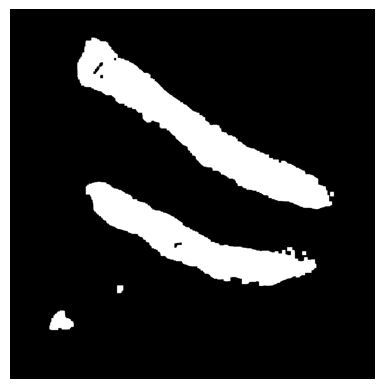

In [8]:
mask = simple_tissue_otsu(thumbnail=thumbnail)
plt.imshow(mask, cmap='gray')
plt.axis('off')

Create an annotation class for our tissue detection annotations


In [9]:
annotation_class = cls.create_annotation_class(annotation_class_name="tissue",
                                               description="Otsu-based tissue detection",
                                               color= "#0000FF")
success = cls.add_annotation_class_to_repo(annotation_class_id=annotation_class.get("id"),
                                           repo_id=repo_id)
success

1

### Convert the mask into contours and insert into to Concentriq as annoations.

In [10]:
annotations = cls.insert_annotations_from_mask(image_id=image_id, 
                                               mask=mask, 
                                               mask_mpp=7,
                                               annotation_class_id=annotation_class.get("id"))

#### Result

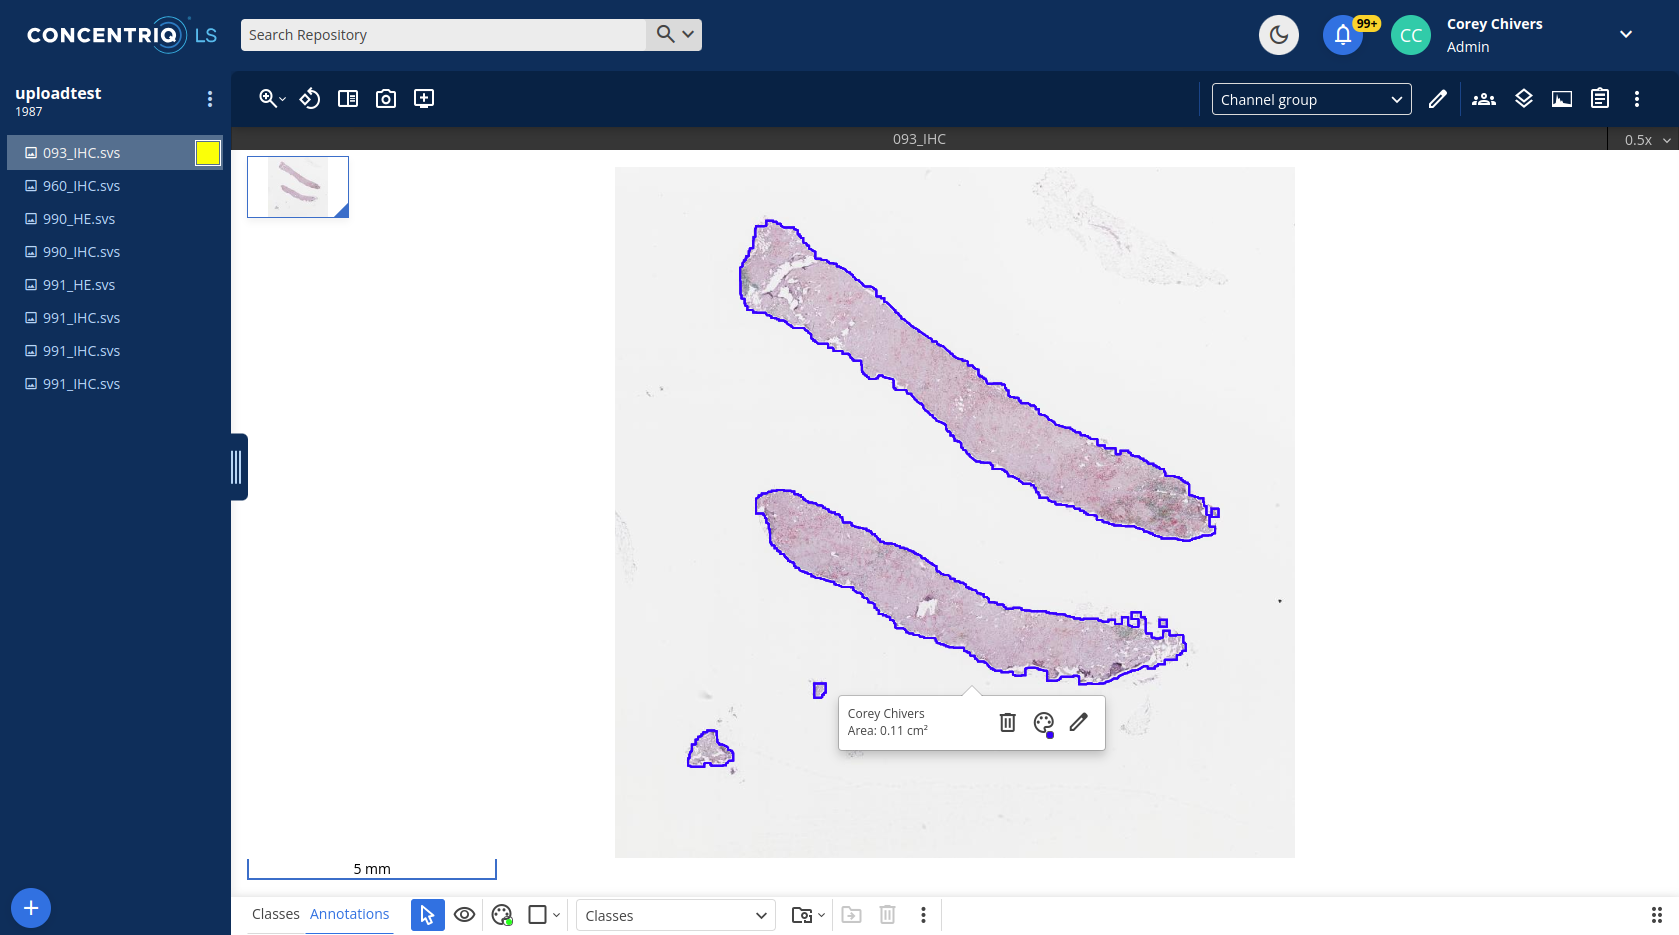